In [1]:
import gc
import torch
import pandas as pd

import matplotlib.pyplot as plt
import utils.print as print_f

from utils.coco_eval import get_ar_ap, get_eval_params_dict
from utils.transforms import get_transform
from utils.engine import xami_train_one_epoch, xami_evaluate
from utils.plot import transparent_cmap, plot_result, plot_loss, get_legend_elements, plot_evaluator
from utils.save import save_model

from data.dataset import ReflacxDataset, collate_fn
from models.rcnn import get_model_instance_segmentation, get_multimodal_model_instance_segmentation

from datetime import datetime
from IPython.display import clear_output
from pycocotools.cocoeval import Params

## Suppress the assignement warning from pandas.
pd.options.mode.chained_assignment = None  # default='warn'

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

In [2]:
# Clean up memory.
gc.collect()
torch.cuda.empty_cache()
# torch.cuda.memory_summary(device=None, abbreviated=False)

In [3]:
XAMI_MIMIC_PATH = "D:\XAMI-MIMIC"

In [4]:
use_gpu = torch.cuda.is_available()
device = 'cuda' if use_gpu else 'cpu'
print(f"This notebook will running on device: [{device}]")

This notebook will running on device: [cuda]


In [5]:
use_clinical = False
clinical_cond = "With" if use_clinical else "Without"

In [6]:
disease_cmap = {
    "transparent": {
        "Enlarged cardiac silhouette": transparent_cmap(plt.cm.autumn),
        "Atelectasis": transparent_cmap(plt.cm.Reds),
        "Pleural abnormality": transparent_cmap(plt.cm.Oranges),
        "Consolidation": transparent_cmap(plt.cm.Greens),
        "Pulmonary edema": transparent_cmap(plt.cm.Blues),
    },
    "solid": {
        "Enlarged cardiac silhouette": "yellow",
        "Atelectasis": "red",
        "Pleural abnormality": "orange",
        "Consolidation": "lightgreen",
        "Pulmonary edema": "dodgerblue",
    },
}

legend_elements = get_legend_elements(disease_cmap["solid"])

In [7]:
labels_cols = [
    "Enlarged cardiac silhouette",
    "Atelectasis",
    "Pleural abnormality",
    "Consolidation",
    "Pulmonary edema",
    #  'Groundglass opacity', # 6th disease.
]

dataset_params_dict = {
    "XAMI_MIMIC_PATH": XAMI_MIMIC_PATH,
    "with_clinical": use_clinical,
    "using_full_reflacx": False,
    "bbox_to_mask": True,
    "labels_cols": labels_cols,
}

detect_eval_dataset = ReflacxDataset(
    **{**dataset_params_dict, "using_full_reflacx": False,},
    transforms=get_transform(train=False),
)

train_dataset = ReflacxDataset(
    **dataset_params_dict, split_str="train", transforms=get_transform(train=True),
)

val_dataset = ReflacxDataset(
    **dataset_params_dict, split_str="val", transforms=get_transform(train=False),
)

test_dataset = ReflacxDataset(
    **dataset_params_dict, split_str="test", transforms=get_transform(train=False),
)

batch_size = 4

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn,
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn,
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn,
)


In [8]:
train_dataset[0]

(tensor([[[0.5608, 0.5608, 0.5569,  ..., 0.0000, 0.0000, 0.0000],
          [0.5569, 0.5647, 0.5647,  ..., 0.0000, 0.0000, 0.0000],
          [0.5490, 0.5569, 0.5608,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.7686, 0.7686, 0.7647,  ..., 1.0000, 1.0000, 1.0000],
          [0.7608, 0.7647, 0.7608,  ..., 1.0000, 1.0000, 1.0000],
          [0.7529, 0.7569, 0.7569,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[0.5608, 0.5608, 0.5569,  ..., 0.0000, 0.0000, 0.0000],
          [0.5569, 0.5647, 0.5647,  ..., 0.0000, 0.0000, 0.0000],
          [0.5490, 0.5569, 0.5608,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.7686, 0.7686, 0.7647,  ..., 1.0000, 1.0000, 1.0000],
          [0.7608, 0.7647, 0.7608,  ..., 1.0000, 1.0000, 1.0000],
          [0.7529, 0.7569, 0.7569,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[0.5608, 0.5608, 0.5569,  ..., 0.0000, 0.0000, 0.0000],
          [0.5569, 0.5647, 0.5647,  ..., 0.0000, 0.0000, 0.0000],
          [0.5490, 0.5569, 0.5608,  ...,

In [9]:
# model = get_model_instance_segmentation(len(train_dataset.labels_cols) +1)
model = get_multimodal_model_instance_segmentation(
    len(train_dataset.labels_cols) +1,
    use_clinical=use_clinical,
)
    
model.to(device)

{'rpn_nms_thresh': 0.3, 'box_detections_per_img': 6, 'box_nms_thresh': 0.2, 'rpn_score_thresh': 0.0, 'box_score_thresh': 0.05}
c1
None


MultimodalMaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu

In [10]:
print(f"Model size: {sum([param.nelement()  for param in model.parameters()]):,}")

Model size: 43,943,923


In [11]:
params = [p for p in model.parameters() if p.requires_grad]
lr_scheduler = None

# construct an optimizer

# optimizer = torch.optim.Adam(params, lr=0.05 ,weight_decay=0.0005)
# lr_scheduler = None

## Original Setting (Kinda work)
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

In [12]:
eval_params_dict = get_eval_params_dict(detect_eval_dataset)

creating index...
index created!


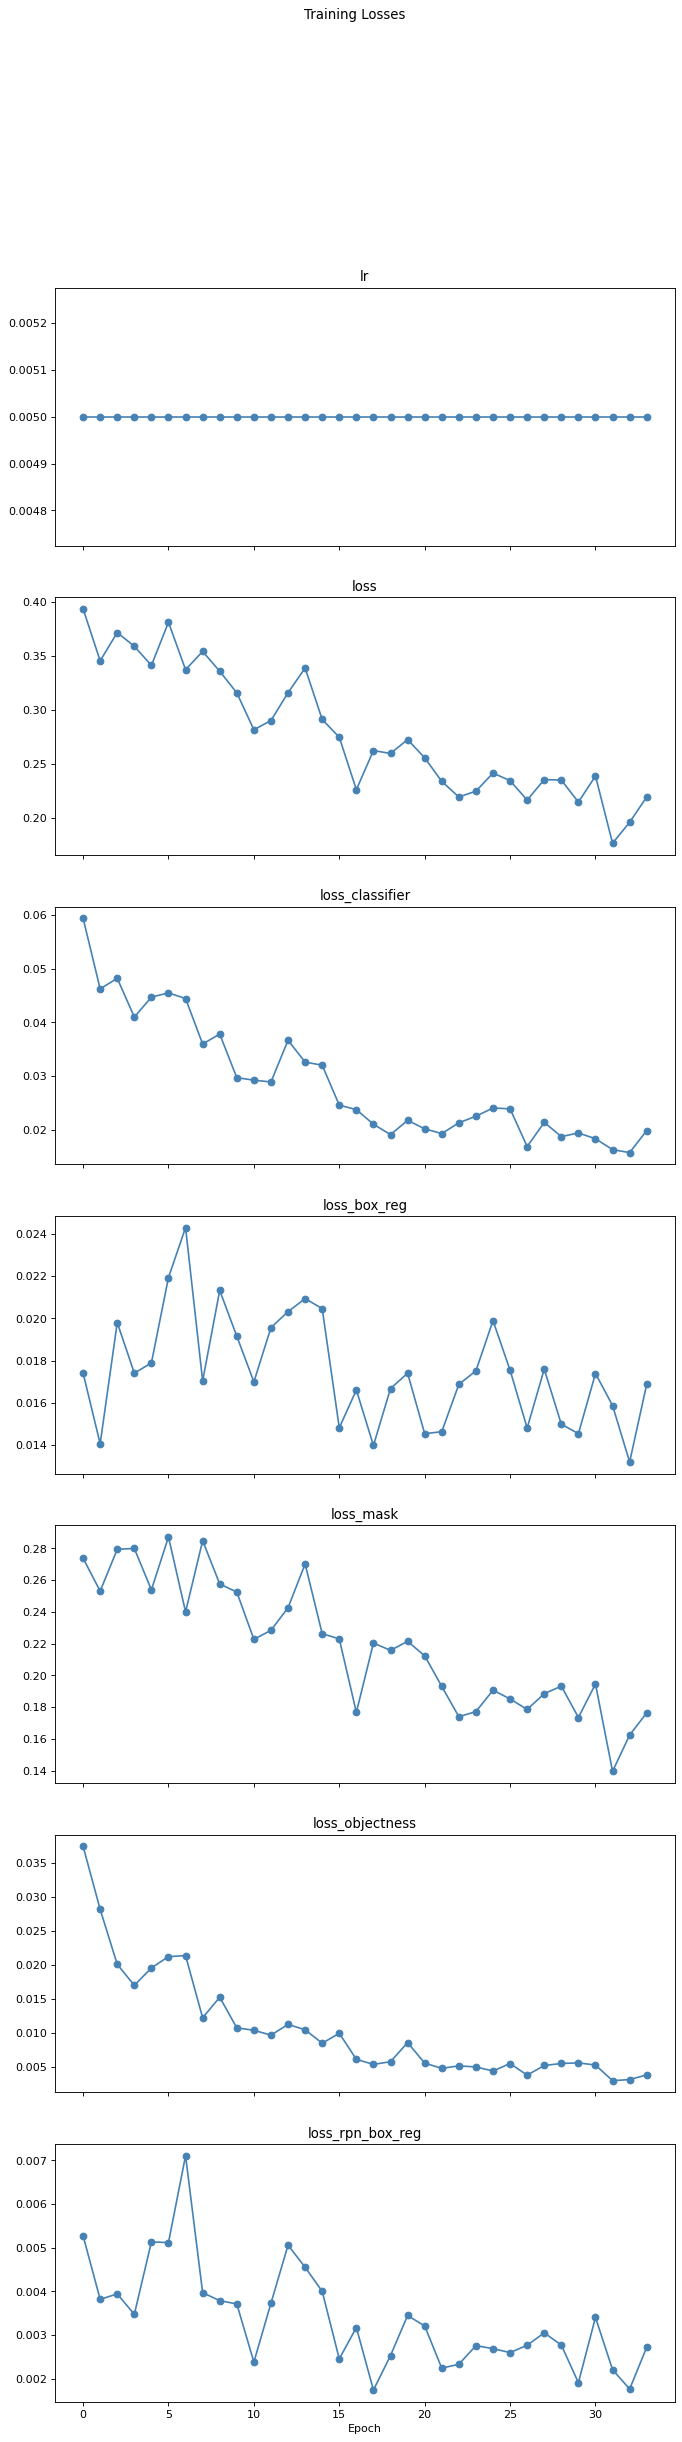

creating index...
index created!
Test:  [ 0/26]  eta: 0:00:29  model_time: 0.3073 (0.3073)  evaluator_time: 0.2284 (0.2284)  time: 1.1322  data: 0.5305  max mem: 2126
Test:  [25/26]  eta: 0:00:00  model_time: 0.1153 (0.1286)  evaluator_time: 0.1110 (0.1335)  time: 0.8243  data: 0.4982  max mem: 2126
Test: Total time: 0:00:21 (0.8346 s / it)
Averaged stats: model_time: 0.1153 (0.1286)  evaluator_time: 0.1110 (0.1335)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.066
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.170
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.041
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | m

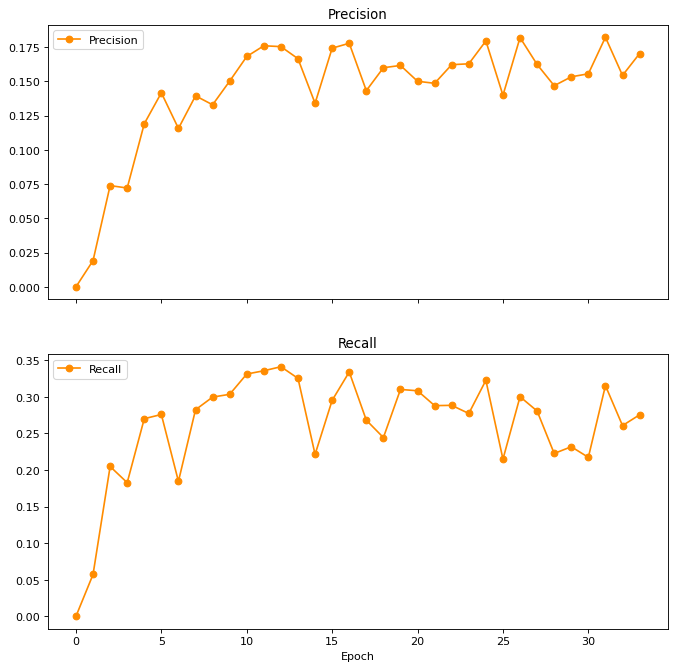

====================| Training Done, start testing! | [54] Epochs Training time: [5042] seconds, Avg time / Epoch: [50.42] seconds====================
Best validation model has been saved to: [val_ar_0_3410_ap_0_1753_test_ar_0_3553_ap_0_1832_epoch33_WithoutClincal_03-14-2022 19-10-27]


In [13]:
num_epochs = 100

best_val_ar = 0
max_patience = 20
current_patience = 0

early_stopping = True

train_logers = []
val_evaluators = []
test_evaluator = None

start_t = datetime.now()

for e in range(20, 100):
    epoch = e + 1

    # train for one epoch, printing every 10 iterations
    model.train()

    train_loger = xami_train_one_epoch(
        model, optimizer, train_dataloader, device, epoch, print_freq=10,
    )

    train_logers.append(train_loger)

    clear_output()

    plot_loss(train_logers)

    model.eval()

    # update the learning rate
    if not lr_scheduler is None:
        lr_scheduler.step()
    # evaluate on the test dataset
    val_evaluator = xami_evaluate(
        model, val_dataloader, device=device, params_dict=eval_params_dict
    )
    val_evaluators.append(val_evaluator)

    plot_evaluator(
        val_evaluators, areaRng="all", iouThr=0.5, maxDets=10,
    )

    if early_stopping:

        val_ar, val_ap = get_ar_ap(val_evaluator)

        ## Targeting the model with higher Average Recall.
        if val_ar > best_val_ar:
            ## Save best validation model
            current_time_string = datetime.now().strftime("%m-%d-%Y %H-%M-%S")

            test_evaluator = xami_evaluate(
                model, test_dataloader, device=device, params_dict=eval_params_dict
            )
            test_ar, test_ap = get_ar_ap(test_evaluator)

            best_val_model_path = save_model(
                epoch=epoch,
                model=model,
                val_ar=val_ar,
                val_ap=val_ap,
                test_ar=test_ar,
                test_ap=test_ap,
                clinical_cond=clinical_cond,
                train_logers=train_logers,
                val_evaluators=val_evaluators,
                test_evaluator=test_evaluator,
            )

            best_val_ar = val_ar
            current_patience = 0
        else:
            current_patience += 1
            if current_patience > max_patience:
                break

    ## plot bbox on the fly.
    # for i in [250, 99, 199]:
    #     plot_result(
    #         model=model,
    #         dataset=detect_eval_dataset,
    #         device=device,
    #         idx=i,
    #         legend_elements=legend_elements,
    #         disease_cmap=disease_cmap,
    #         seg=False,
    #         seg_thres=0.5,
    #     )

end_t = datetime.now()
sec_took = (end_t - start_t).seconds

print_f.print_title(
    f"| Training Done, start testing! | [{epoch}] Epochs Training time: [{sec_took}] seconds, Avg time / Epoch: [{sec_took/num_epochs}] seconds"
)

# print model
if early_stopping:
    print(f"Best validation model has been saved to: [{best_val_model_path}]")
else:
    test_evaluator = xami_evaluate(
        model, test_dataloader, device=device, params_dict=eval_params_dict
    )

    val_ar, val_ap = get_ar_ap(val_evaluator)
    test_ar, test_ap = get_ar_ap(test_evaluator)

    final_model_path = save_model(
        epoch=epoch,
        model=model,
        val_ar=val_ar,
        val_ap=val_ap,
        test_ar=test_ar,
        test_ap=test_ap,
        clinical_cond=clinical_cond,
        train_logers=train_logers,
        val_evaluators=val_evaluators,
        test_evaluator=test_evaluator,
    )

    print(f"The final model has been saved to: [{final_model_path}]")


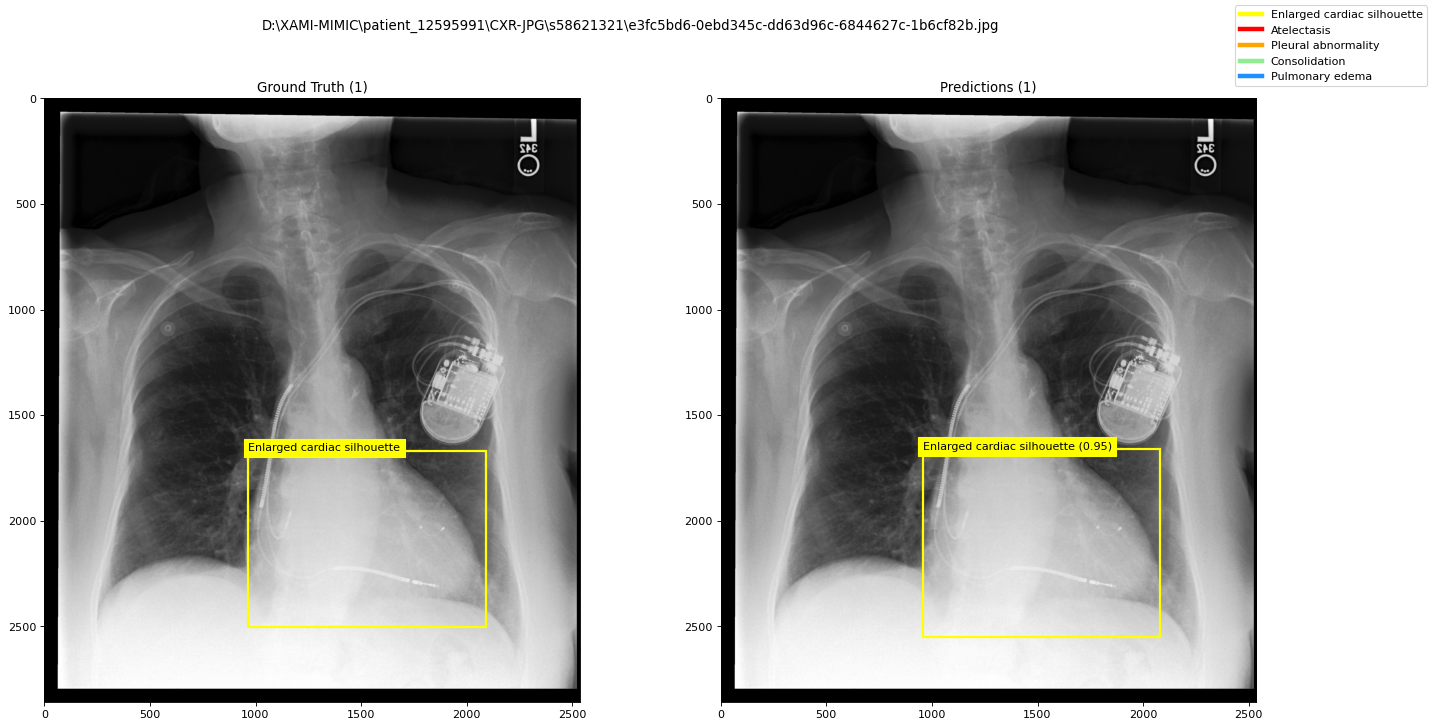

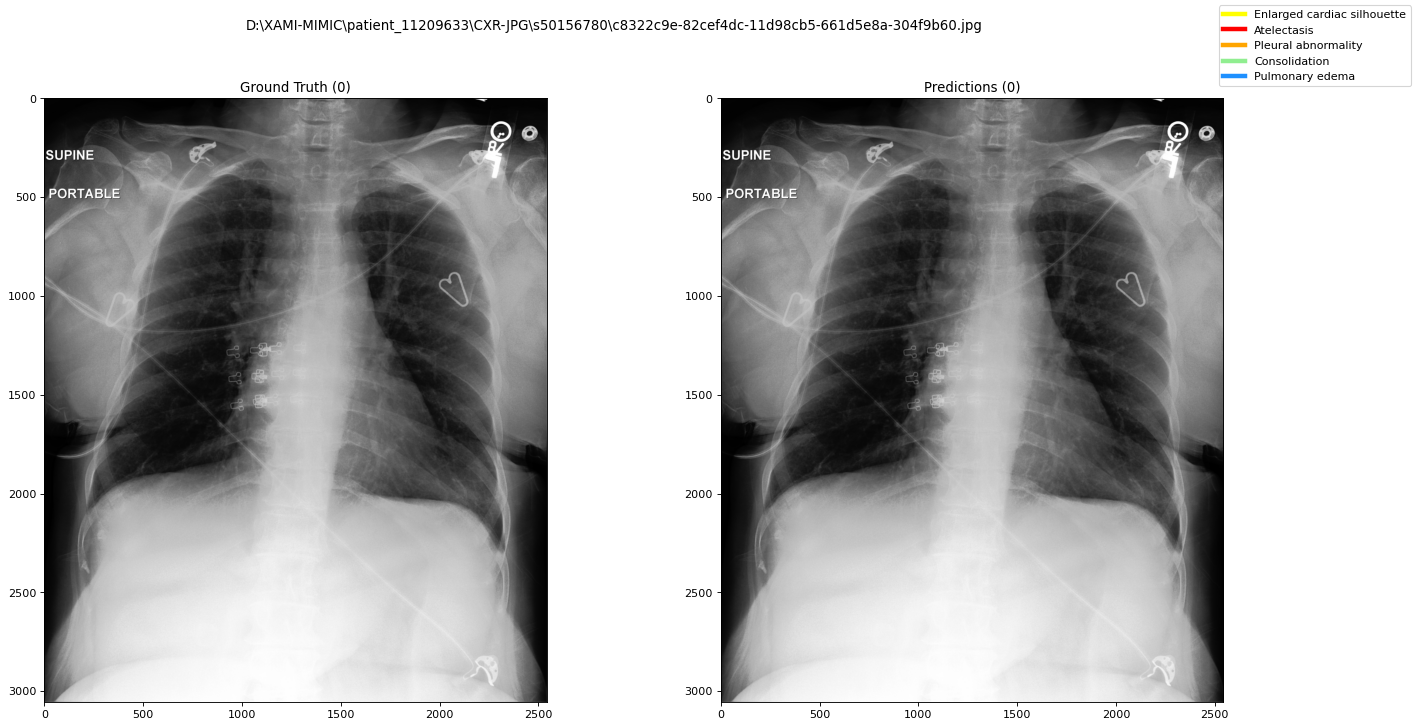

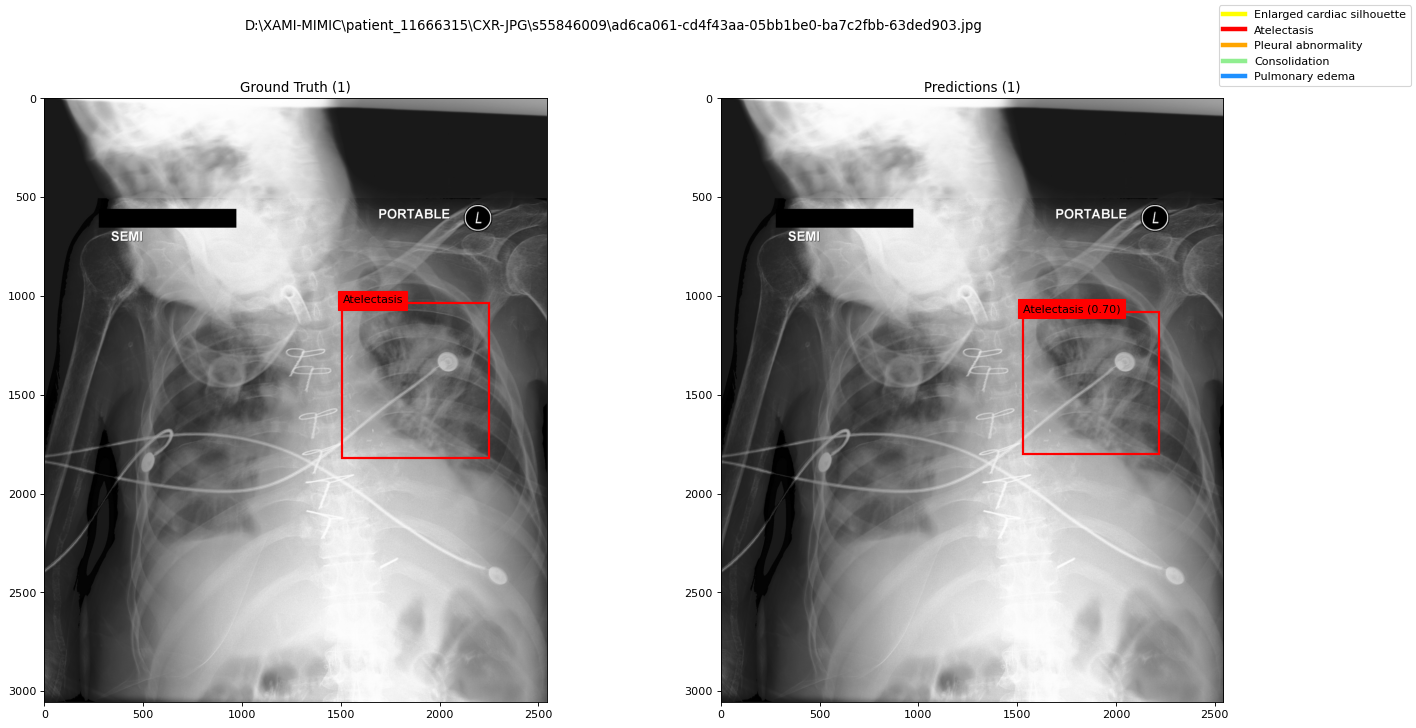

In [14]:
model.roi_heads.score_thresh = 0.3
for i in [250, 99, 199]:
    plot_result(
        model=model,
        dataset=detect_eval_dataset,
        device=device,
        idx= i,
        legend_elements= legend_elements,
        disease_cmap =disease_cmap,
        seg=False,
        seg_thres=0.5,
    )

In [15]:
# chekcing if a part of the model is being trained.
# for sector in [model.clinical_convs, model.fuse_convs]:
#     print(
#         sum(
#             [
#                 sum([p.grad.abs().sum() for p in model.clinical_convs[k].parameters()])
#                 for k in sector.keys()
#             ]
#         )
#     )

In [16]:
# test_evaluator.summarize()

In [17]:
# eval_params_dict = get_eval_params_dict(detect_eval_dataset)
# params_test_evaluator = xami_evaluate(model, test_dataloader, device=device, params_dict=eval_params_dict)
# params_test_evaluator.summarize()

In [18]:
# _ = external_summarize(
#     params_test_evaluator.coco_eval["bbox"],
#     ap=1,
#     iouThr=0.5,
#     areaRng="all",
#     maxDets=6,
#     print_result=True,
# )
# _ = external_summarize(
#     params_test_evaluator.coco_eval["bbox"],
#     ap=0,
#     iouThr=0.5,
#     areaRng="all",
#     maxDets=6,
#     print_result=True,
# )

In [19]:
# current_time_string = datetime.now().strftime("%m-%d-%Y %H-%M-%S")
# final_model_path =  f"epoch{epoch}_{clinial_cond}Clincal_{current_time_string}".replace(":", "_").replace(".", "_")

In [20]:
# torch.save(model.state_dict(), os.path.join(
#     os.path.join('trained_models', final_model_path)
# ))

# print(f"Model has been saved: {final_model_path}")

In [21]:
# training_record = OrderedDict({
#     "train_data": [ get_train_data(loger) for loger in train_logers],
#     "val_evaluators" : val_evaluators,
#     "test_evaluator": test_evaluator,
# })

# with open(
#     os.path.join("training_records", f"{final_model_path}.pkl"), "wb",
# ) as training_record_f:
#     pickle.dump(training_record, training_record_f)

In [22]:
# epoch99_WithoutClincal_03-11-2022 09-05-17  (custom)
# epoch99_WithClincal_03-11-2022 17-34-14 (custom)
# epoch99_WithoutClincal_03-12-2022 07-56-08 (original)

In [24]:
## 20 epoch each.
# val_ar_0_2536_ap_0_1206_test_ar_0_2864_ap_0_1256_epoch20_WithoutClincal_03-13-2022 23-20-30 (original)
# val_ar_0_3397_ap_0_1889_test_ar_0_3146_ap_0_1402_epoch20_WithoutClincal_03-14-2022 00-30-30 (custom)
# val_ar_0_3212_ap_0_1481_test_ar_0_2996_ap_0_1704_epoch20_WithClincal_03-14-2022 01-45-59 (custom)

In [25]:
## Eearly stopiing (20 patience)
# val_ar_0_3000_ap_0_1542_test_ar_0_3504_ap_0_1386_epoch15_WithoutClincal_03-14-2022 03-10-11 (original)
# val_ar_0_3410_ap_0_1753_test_ar_0_3553_ap_0_1832_epoch33_WithoutClincal_03-14-2022 19-10-27(custom)
# val_ar_0_3909_ap_0_1828_test_ar_0_3808_ap_0_1542_epoch39_WithClincal_03-14-2022 17-14-52(custom)